## Deduplication of modelling dataset

We are using a deduplication by DOI.

In [7]:
# Libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [44]:
# Read initial data, merging csv files from each database
pattern_wos = sorted(glob.glob("./bulk_data/model_wos_[0-9]*.csv"))
dfModellingWOSList = [pd.read_csv(file_name, sep='\t') for file_name in pattern_wos]
dfModellingWOSOriginal = pd.concat(dfModellingWOSList, ignore_index=True)

pattern_scopus = sorted(glob.glob("./bulk_data/model_scopus_[0-9]*.csv"))
dfModellingScopusList = [pd.read_csv(file_name, sep=',') for file_name in pattern_scopus]
dfModellingScopusOriginal = pd.concat(dfModellingScopusList, ignore_index=True)

# Drop duplicates in Scopus using scopus id.
dfModellingScopusOriginal = dfModellingScopusOriginal.drop_duplicates(subset=['EID'], keep='first')

## Fill source for WoS papers
dfModellingWOSOriginal['source'] = 'Web of Science'

## Remove papers without DOI
dfModellingScopus = dfModellingScopusOriginal[dfModellingScopusOriginal['DOI'].notnull()]
dfModellingWOS = dfModellingWOSOriginal[dfModellingWOSOriginal['DI'].notnull()]

## Converting DOI to lowercase
dfModellingScopus.loc[:, 'DOI'] = dfModellingScopus['DOI'].str.lower()
dfModellingWOS.loc[:, 'DI'] = dfModellingWOS['DI'].str.lower()

# Print size of dataframes and removed papers
removed_scopus = len(dfModellingScopusOriginal) - len(dfModellingScopus)
removed_WOS = len(dfModellingWOSOriginal) - len(dfModellingWOS)
print('Scopus len:', len(dfModellingScopus), ', removed', removed_scopus, 'without DOI')
print('WoS len:', len(dfModellingWOS), 'removed', removed_WOS, 'without DOI')

# Print columns name
print('Scopus columns:', dfModellingScopus.columns.values)
print('WoS columns:', dfModellingWOS.columns.values)

Scopus len: 15075 , removed 274 without DOI
WoS len: 16714 removed 237 without DOI
Scopus columns: ['Authors' 'Author(s) ID' 'Title' 'Year' 'Source title' 'Volume' 'Issue'
 'Art. No.' 'Page start' 'Page end' 'Page count' 'Cited by' 'DOI' 'Link'
 'Affiliations' 'Authors with affiliations' 'Abstract' 'Author Keywords'
 'Index Keywords' 'References' 'Editors' 'Publisher' 'ISSN' 'ISBN' 'CODEN'
 'Language of Original Document' 'Document Type' 'Publication Stage'
 'Open Access' 'Source' 'EID']
WoS columns: ['PT' 'AU' 'BA' 'BE' 'GP' 'AF' 'BF' 'CA' 'TI' 'SO' 'SE' 'BS' 'LA' 'DT'
 'CT' 'CY' 'CL' 'SP' 'HO' 'DE' 'ID' 'AB' 'C1' 'C3' 'RP' 'EM' 'RI' 'OI'
 'FU' 'FP' 'FX' 'CR' 'NR' 'TC' 'Z9' 'U1' 'U2' 'PU' 'PI' 'PA' 'SN' 'EI'
 'BN' 'J9' 'JI' 'PD' 'PY' 'VL' 'IS' 'PN' 'SU' 'SI' 'MA' 'BP' 'EP' 'AR'
 'DI' 'DL' 'D2' 'EA' 'PG' 'WC' 'WE' 'SC' 'GA' 'PM' 'OA' 'HC' 'HP' 'DA'
 'UT' 'source']


In [45]:
# Rename columns

columns_scopus = [
    'Title', 'Authors', 'DOI', 'Source title', 'Year', 'Cited by', 
    'Author Keywords', 'Affiliations', 'Abstract', 'References', 'Publisher', 'ISSN', 
    'Language of Original Document', 'Document Type', 'Source'
]

columns_wos = [
    'TI', 'AU', 'DI', 'SO', 'PY', 'Z9', 
    'DE', 'C3', 'AB', 'CR', 'PU', 'SN', 
    'LA', 'DT', 'source'
]

final_columns = [
    'title', 'authors', 'DOI', 'journal_name', 'year', 'number_citation', 
    'author_keywords', 'affiliations', 'abstract', 'references', 'publisher', 'ISSN', 
    'language', 'document_type', 'source'
]

drop_columns = set(dfModellingScopus.columns.values) - set(columns_scopus)
rename_columns = dict(zip(columns_scopus, final_columns))
dfModellingScopus = dfModellingScopus.drop(columns=drop_columns)
dfModellingScopus = dfModellingScopus.rename(columns=rename_columns)

drop_columns = set(dfModellingWOS.columns.values) - set(columns_wos)
rename_columns = dict(zip(columns_wos, final_columns))
dfModellingWOS = dfModellingWOS.drop(columns=drop_columns)
dfModellingWOS = dfModellingWOS.rename(columns=rename_columns)

In [46]:
scopus_without_ISSN = len(dfModellingScopus[dfModellingScopus['ISSN'].isnull()])
print(f'In scopus {scopus_without_ISSN} ({scopus_without_ISSN / len(dfModellingScopus)}) papers are without ISSN')
# In scopus all of them are conference paper
print(f"They have type {dfModellingScopus[dfModellingScopus['ISSN'].isnull()]['document_type'].unique()}")

wos_without_ISSN = len(dfModellingWOS[dfModellingWOS['ISSN'].isnull()])
print(f'In WoS {wos_without_ISSN} ({wos_without_ISSN / len(dfModellingWOS)}) papers are without ISSN')
# in wos they have different origins
print(f"They have type {dfModellingWOS[dfModellingWOS['ISSN'].isnull()]['document_type'].unique()}")

In scopus 1 (6.633499170812604e-05) papers are without ISSN
They have type ['Article']
In WoS 1916 (0.11463443819552471) papers are without ISSN
They have type ['Article' 'Article; Early Access' 'Article; Proceedings Paper'
 'Article; Data Paper']


In [47]:
# If the paper is duplicated in the databases complete missing values from Scopus using WoS. 
# Also mark duplicated papers.

for idx, row in dfModellingScopus.iterrows():
    dfModellingWOSDuplicate = dfModellingWOS.loc[dfModellingWOS['DOI']== row.DOI]
    
    if not dfModellingWOSDuplicate.empty:
        dfModellingScopus.loc[idx, 'source'] = 'Scopus;Web of Science'

        if pd.isna(row['year']) and pd.notna(dfModellingWOSDuplicate['year'].values[0]): 
            dfModellingScopus.loc[idx, 'year'] = dfModellingWOSDuplicate['year'].values[0]
        if pd.isna(row['author_keywords']) and pd.notna(dfModellingWOSDuplicate['author_keywords'].values[0]): 
            dfModellingScopus.loc[idx, 'author_keywords'] = dfModellingWOSDuplicate['author_keywords'].values[0]
        if pd.isna(row['number_citation']) and pd.notna(dfModellingWOSDuplicate['number_citation'].values[0]): 
            dfModellingScopus.loc[idx, 'number_citation'] = dfModellingWOSDuplicate['number_citation'].values[0]

# Merge dataframes and remove duplicates by DOI 
dfModelling = pd.concat([dfModellingScopus, dfModellingWOS], ignore_index=True)[final_columns]
dfModelling = dfModelling.drop_duplicates(subset=['DOI'], keep='first')

In [48]:
# Cleaning dataframe before saving

# Add date of export
dfModelling['date_export'] = '2023-03-16'

# Add link from DOI
dfModelling['link'] = 'https://dx.doi.org/' + dfModelling['DOI']

# Clean strings for ISSN and journal_name
dfModelling['ISSN'] = dfModelling['ISSN'].str.replace('[^\w\s]','')
dfModelling['journal_name'] = dfModelling['journal_name'].str.capitalize()

# For now consider only Article, removing proceedings
dfModelling = dfModelling[dfModelling['document_type'] == 'Article']

# Unify journal_name
for name, group in dfModelling[dfModelling['ISSN'].notnull()].groupby('ISSN'):
    different_names = group['journal_name'].unique()
    
    if len(different_names) > 1:
        scopus_names = sorted(group[group['source'] != 'Web of Science']['journal_name'].unique())
        correct_name = scopus_names[0] if scopus_names else different_names[0]

        for alternative_name in (set(different_names) - {correct_name}):
            dfModelling.loc[dfModelling['journal_name'] == alternative_name, 'journal_name'] = correct_name
            #print(f'{alternative_name} renamed to {correct_name}')
            
# Reset index
dfModelling.reset_index(drop=True, inplace=True)

British journal of psychology (london, england : 1953) renamed to British journal of psychology
Journal of psychology: interdisciplinary and applied renamed to Journal of psychology
Social work (united states) renamed to Social work
Leadership and organization development journal renamed to Leadership & organization development journal
Journal of geophysical research: biogeosciences renamed to Journal of geophysical research
Agricultural economics (united kingdom) renamed to Agricultural economics
Omega (united kingdom) renamed to Omega
Journal of water resources planning and management-asce renamed to Journal of water resources planning and management
Journal of environmental engineering (united states) renamed to Journal of environmental engineering
Disaster prevention and management: an international journal renamed to Disaster prevention and management
Shengtai xuebao/ acta ecologica sinica renamed to Shengtai xuebao
The family journal renamed to Family journal
Sensors (switzerland

In [49]:
# Print length of final dataset
print('Final length:', len(dfModelling))

# Save dataset
dfModelling.to_csv('data/modelling.csv', index_label='index')

Final length: 19214


## Computing basic statistics of modelling dataset

In [50]:
sns.set_context(rc = {'patch.linewidth': 0.0})

In [55]:
len(dfModelling['year'].unique())

24

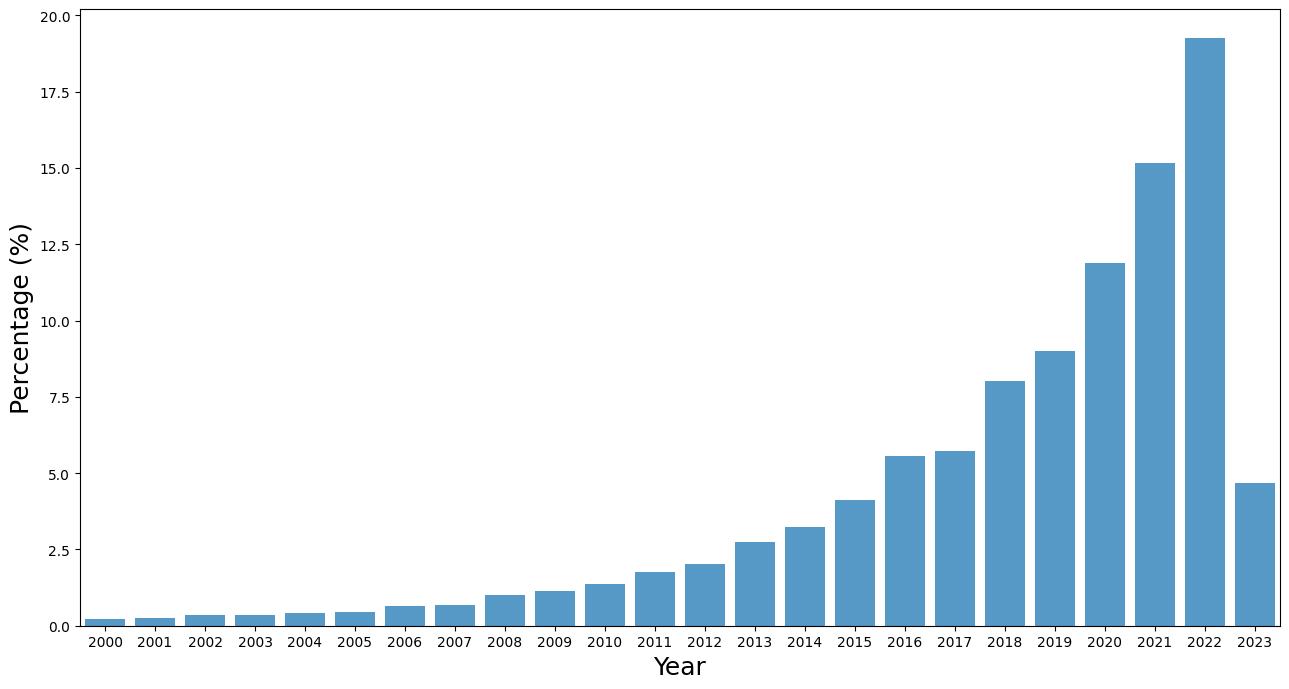

In [74]:
plt.figure(figsize=(13, 7))
sns.histplot(data=dfModelling[dfModelling.year.notnull()], x='year', stat='percent', bins=24, shrink=.8)

plt.xticks(np.arange(2000.48, 2023.3, step=0.958), np.arange(2000, 2024, step=1)) 
plt.xlim(2000, 2023)
plt.xlabel("Year", fontsize=18)
plt.ylabel("Percentage (%)", fontsize=18)
plt.tight_layout()
plt.show()

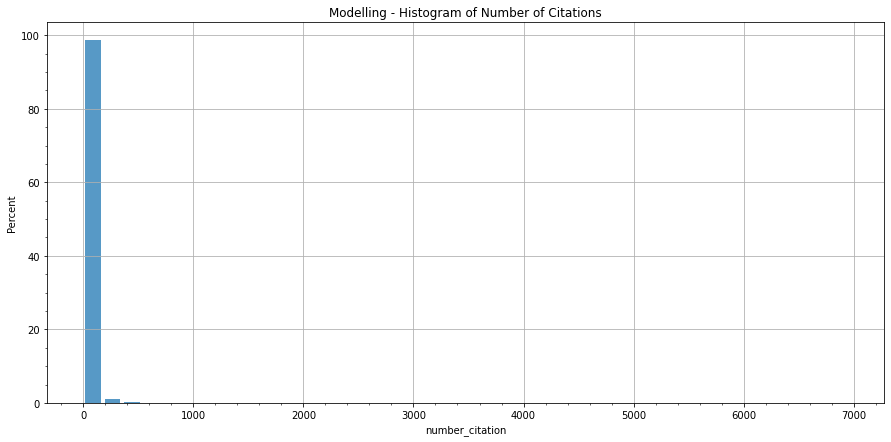

More than  200 citations 215
Removing less than 5 citations:  18333 papers


In [10]:
cut_line = 200

plt.figure(figsize=(15, 7))

sns.histplot(
    data=dfModelling[dfModelling['number_citation'].notnull()], x='number_citation', stat='percent', bins=39, shrink=.8
)

plt.title('Modelling - Histogram of Number of Citations')
plt.minorticks_on()
plt.grid()
plt.show()

print('More than ', cut_line, 'citations', (dfModelling['number_citation'] > cut_line).sum())
print('Removing less than 5 citations: ', len(dfModelling) - 881, 'papers')

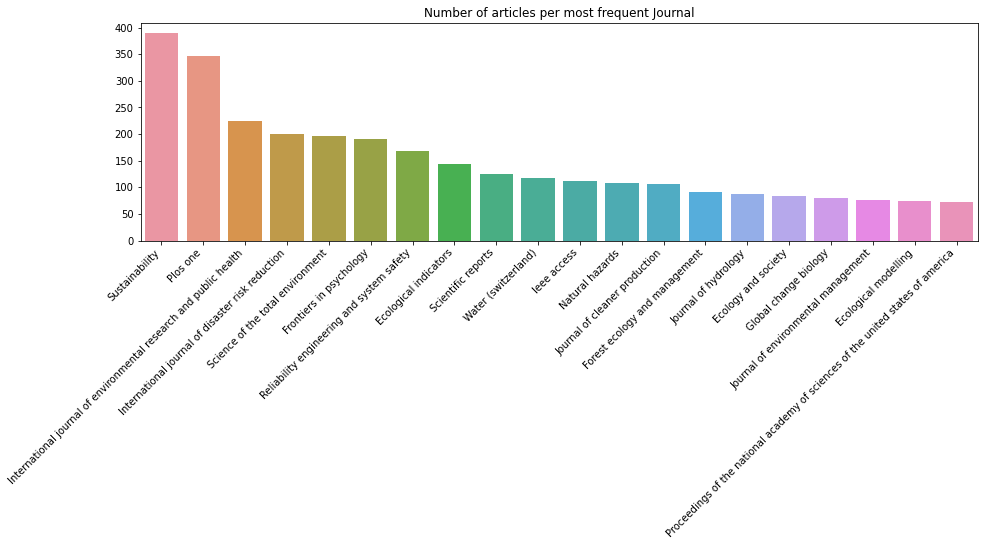

In [11]:
plt.figure(figsize=(15, 4))

dfPlot = dfModelling['journal_name'].value_counts().head(20)

sns.barplot(x=dfPlot.index, y=dfPlot.values)

plt.title('Number of articles per most frequent Journal')
plt.xticks(rotation=45, ha='right')
plt.show()

In [12]:
dfModelling['journal_name'].value_counts().head(40)

Sustainability                                                                     389
Plos one                                                                           346
International journal of environmental research and public health                  225
International journal of disaster risk reduction                                   200
Science of the total environment                                                   196
Frontiers in psychology                                                            191
Reliability engineering and system safety                                          168
Ecological indicators                                                              144
Scientific reports                                                                 125
Water (switzerland)                                                                118
Ieee access                                                                        112
Natural hazards                            